In [ ]:
#from google.colab import drive
#drive.mount('/content/google_drive')

Mounted at /content/google_drive


In [ ]:
print('\n-----------------------------------------------------------------------------------------------')
print('( ) Loading libraries')
print('-----------------------------------------------------------------------------------------------')
!python -m pip install rioxarray==0.14.1 &> /dev/null


-----------------------------------------------------------------------------------------------
( ) Loading libraries
-----------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import os
import json
import geopandas as gpd
import shutil
import rioxarray as rxr
import matplotlib.pyplot as plt
from glob import glob
# Earth Engine
import ee
import requests

In [ ]:
def check_projection(shp_file_path):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1) Check projection of shapefile')
  print('-----------------------------------------------------------------------------------------------')
  # find name of shapefile
  for shp_file in os.listdir(os.path.join(shp_file_path)):
      if shp_file.endswith(".shp"):
        shp_file_name = shp_file
  print('Shapefile name: ', shp_file_name)
  print('Shapefile path: ', os.path.join(variable['main_dir'], "shapefile",shp_file_name))
  shp_lyr_check = gpd.read_file(os.path.join(variable['main_dir'], "shapefile",shp_file_name))
  print('Shapefile CRS: ', shp_lyr_check.crs)

  temp_dir = os.path.join(variable['temporary_dir'])
  if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

  if shp_lyr_check.crs != 'EPSG:4326':
    # reproject
    shp_lyr_crs = shp_lyr_check.to_crs(epsg=4326)
    shp_lyr_crs.to_file(os.path.join(variable['temporary_dir'],shp_file_name))
    print('Shapefile layer has been reprojected to match shapefile')
  else:
    shp_lyr_crs = shp_lyr_check
    print('Coordinate systems match!')
    shp_lyr_crs.to_file(os.path.join(variable['temporary_dir'],shp_file_name))

  return(shp_file_name)

In [ ]:
def download_soil(shp_file_path, shp_file_name, data_source, year_of_interest, band_name, scale):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1a) Download Soil')
  print('-----------------------------------------------------------------------------------------------')
  # trigger the authentication flow
  ee.Authenticate()
  # initialize the library
  ee.Initialize()
  # define buffer
  buffer_size = 0.3

  # determine the boundary of the provided shapefile
  bounds = gpd.read_file(os.path.join(shp_file_path, shp_file_name)).bounds
  west, south, east, north = bounds = bounds.loc[0]
  west -= buffer_size
  south -= buffer_size
  #north -= buffer_size
  #east -= buffer_size
  print('Bounding box: ',west, south, east, north)

  # concat input data to generate full path
  full_data_source = data_source+'/'+year_of_interest+'_01_01'

  img = ee.Image(data_source)
  region = ee.Geometry.BBox(west, south, east, north)

  # Multi-band GeoTIFF file.
  url = img.getDownloadUrl({
      'bands': [band_name],
      'region': region,
      'scale': scale,
      'format': 'GEO_TIFF'
  })

  # define output directory
  soil_dir = os.path.join(variable['temporary_dir'],'Soil')
  if not os.path.exists(soil_dir):
    os.makedirs(soil_dir)

  response = requests.get(url)
  with open(os.path.join(soil_dir,'study_area_soil.tif'), 'wb') as fd:
    fd.write(response.content)

  # path to clipped output file
  clipped_bounds = os.path.join(soil_dir, 'study_area_soil.tif')

  # path to cleaned and clipped output file
  soil_filled = os.path.join(soil_dir, 'soil_filled.tif')

  # define bash script directory
  bash_dir = os.path.join(variable['temporary_dir'],'bash_scripts')
  bash_path = os.path.isdir(bash_dir)
  if not bash_path:
    os.makedirs(bash_dir)
    print("created  folder: ", bash_dir)

  # gdal fill no data
  with open(os.path.join(bash_dir,'fillnodata.sh'), 'w') as f1:
      print(f'gdal_fillnodata.py -md 10 -b 1 -of GTiff "{clipped_bounds}" "{soil_filled}"', file=f1)
  # format bash command
  fill_data = os.path.join(bash_dir, 'fillnodata.sh')
  #run bash command
  !bash {fill_data}

  # remove old unfilled soil layer
  os.remove(clipped_bounds)
  return(soil_dir)

In [ ]:
def overlay_shp_on_soil(shp_file_path, shp_file_name):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(2) Overlay shapefile on soil')
  print('-----------------------------------------------------------------------------------------------')
  # find name of raster
  for tif_file in os.listdir(os.path.join(variable['temporary_dir'],'Soil')):
      if tif_file.endswith(".tif"):
        tif_file_name = tif_file
  # open raster
  soil_lyr = rxr.open_rasterio(os.path.join(variable['temporary_dir'],'Soil',tif_file_name), masked=True).squeeze()
  # load shapefile
  crop_extent= gpd.read_file(os.path.join(variable['temporary_dir'], shp_file_name))

  print('Shapefile CRS: ', crop_extent.crs)
  print('Soil CRS: ', soil_lyr.rio.crs)

  if crop_extent.crs !=  soil_lyr.rio.crs:
    # reproject
    soil_lyr = soil_lyr.rio.reproject(crop_extent.crs)
    print('Soil layer has been reprojected to match shapefile')
  else:
    print('Coordinate systems match!')

  f, ax = plt.subplots(figsize=(10, 5))
  soil_lyr.plot.imshow(ax=ax)

  crop_extent.plot(ax=ax,alpha=.8, color="black")
  ax.set(title="Raster Layer with Shapefile Overlayed")

  ax.set_axis_off()

  soil_shapfile_visualization = True

  if soil_shapfile_visualization == True:
    plt.show()
  return(soil_lyr, crop_extent)

In [ ]:
def clip_and_format(soil_dir, soil_lyr, crop_extent):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(3) Clip and format soil into shapefile')
  print('-----------------------------------------------------------------------------------------------')
  # Clip soil product to study area

  # open crop extent (the study area extent boundary)
  crop_extent1 = crop_extent.buffer(.001)

  # clip the DEM layer
  lidar_clipped = soil_lyr.rio.clip(crop_extent1, crop_extent1.crs)
  print('Soil layer has been clipped')

  # save clipped DEM layer to drive
  path_to_tif_file = os.path.join(soil_dir, 'clipped_lyr.tif')
  lidar_clipped.rio.to_raster(path_to_tif_file)
  print('Layer has been saved to temporary folder')

  # define Pathways Necessary for GDAL Commands
  # name of shapefile
  clip_name = 'studyArea_outline'

  # path to clipped output file
  clipped = os.path.join(soil_dir, 'clipped.tif')

  # path to cleaned and clipped output file
  clipped_lyr = os.path.join(soil_dir, 'clipped_lyr.tif')

  # path to soil shapefile
  soil_shp = os.path.join(soil_dir, 'studyArea_soil.shp')

  # define bash script directory
  bash_dir = os.path.join(variable['temporary_dir'],'bash_scripts')
  bash_path = os.path.isdir(bash_dir)
  if not bash_path:
    os.makedirs(bash_dir)
    print("created  folder: ", bash_dir)

  # gdal polygonize
  with open(os.path.join(bash_dir,'polygon.sh'), 'w') as f3:
      print(f'gdal_polygonize.py "{clipped_lyr}" "{soil_shp}" -b 1 -f "ESRI Shapefile"', file=f3)
  # define bash command path
  polygon_sh = os.path.join(bash_dir, 'polygon.sh')

  # run bash command
  !bash {polygon_sh}

In [ ]:
def visualize_soil(soil_dir):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(4) Visualize soil outputs')
  print('-----------------------------------------------------------------------------------------------')
  # find name of shapefile
  for soil_shp_file in os.listdir(soil_dir):
      if soil_shp_file.endswith(".shp"):
        soil_shp_file_name = soil_shp_file
  soil_shp = gpd.read_file(os.path.join(soil_dir, soil_shp_file_name))
  soil_dissolve = soil_shp.dissolve(by='DN')
  soil_dissolve["Soil_ID"]= soil_dissolve.index
  soil_final = soil_dissolve.reset_index()
  soil_final = soil_final.drop('DN', axis=1)
  display(soil_final)

  soil_output_dir = os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'Soil')
  if not os.path.exists(soil_output_dir):
    os.makedirs(soil_output_dir)

  # save final soil shapefile to drive
  soil_final.to_file(os.path.join(soil_output_dir,'studyArea_soil.shp'))

  print('------------------------------------- Soil -------------------------------------')
  soil_final = gpd.read_file(os.path.join(soil_output_dir,'studyArea_soil.shp'))
  f, ax = plt.subplots(figsize=(8,9))
  soil_final.plot(column='Soil_ID',categorical=True,legend=True ,ax=ax)
  ax.set_axis_off()
  plt.show()

  soil_final['area'] = soil_final.area

  df_S1 = pd.DataFrame(soil_final.drop(columns='geometry'))
  df_soil = df_S1.groupby('Soil_ID').sum()
  df_soil.reset_index(inplace=True)
  # collect unique landcover IDs
  unique_soil = df_soil['Soil_ID'].unique()
  # get length of unique landcover IDs
  un_soi_len_lst = list(range(unique_soil.size))

  for val_s in unique_soil:
      area_poly_S = df_soil.loc[df_soil['Soil_ID'] == val_s, 'area']
      soil_area = float((area_poly_S/df_soil['area'].sum())*100)
      for num in un_soi_len_lst:
        if val_s == unique_soil[num]:
          print(f'ID ({val_s}): {round(soil_area,2)}%')

  print('\n-----------------------------------------------------------------------------------------------')
  print('(4) Soil is complete!')
  print('-----------------------------------------------------------------------------------------------')

In [ ]:
def upload_soil(soil_temp_dir):
  # find name of shapefile
  for shp_file in os.listdir(os.path.join(variable['main_dir'], 'shapefile')):
      if shp_file.endswith(".shp"):
        shp_file_name = shp_file

  # find name of shapefile
  for soil_file in os.listdir(soil_temp_dir):
      if soil_file.endswith(".shp"):
        soil_file_name = soil_file

  print('\n-----------------------------------------------------------------------------------------------')
  print('(2) Check Projection')
  print('-----------------------------------------------------------------------------------------------')

  # load study area shapefile
  shp_extent = gpd.read_file(os.path.join(variable['main_dir'], 'shapefile', shp_file_name))
  # load soil shapefile
  soil_extent = gpd.read_file(os.path.join(soil_temp_dir, soil_file_name))
  if 'Soil_ID' in soil_extent:
    if shp_extent.crs !=  soil_extent.crs:
      # reproject
      soil_lyr = soil_lyr.to_crs(shp_extent.crs)
      print('\nSoil layer has been reprojected to match shapefile')
    else:
      soil_lyr = soil_extent
      print('\nCoordinate systems match')

    print('\n-----------------------------------------------------------------------------------------------')
    print('(3) Visualize and save soil layer')
    print('-----------------------------------------------------------------------------------------------')

    # check out table
    display(soil_lyr)

    # visualize soil
    f, ax = plt.subplots(figsize=(8,9))
    soil_lyr.plot(column='Soil_ID',categorical=True,legend=True ,ax=ax)
    ax.set_axis_off()
    plt.show()

    soil_lyr['area'] = soil_lyr.area

    df_S1 = pd.DataFrame(soil_lyr.drop(columns='geometry'))
    df_soil = df_S1.groupby('Soil_ID').sum()
    df_soil.reset_index(inplace=True)
    # collect unique landcover IDs
    unique_soil = df_soil['Soil_ID'].unique()
    # get length of unique landcover IDs
    un_soi_len_lst = list(range(unique_soil.size))

    for val_s in unique_soil:
        area_poly_S = df_soil.loc[df_soil['Soil_ID'] == val_s, 'area']
        soil_area = float((area_poly_S/df_soil['area'].sum())*100)
        for num in un_soi_len_lst:
          if val_s == unique_soil[num]:
            print(f'ID ({val_s}): {round(soil_area,2)}%')

    # save final soil shapefile to drive
    soil_output_dir = os.path.join(variable['main_dir'], 'workflow_outputs', '1_HRU_data','Soil')
    if not os.path.exists(soil_output_dir):
      os.makedirs(soil_output_dir)
    soil_lyr.to_file(os.path.join(soil_output_dir,'studyArea_soil.shp'))
  else:
    print('--- Invalid soil column name ---\n')
    print('please change soil column name to Soil_ID and run again')

In [ ]:
def remove_temp_data():
  if os.path.exists(os.path.join(variable['temporary_dir'])):
    shutil.rmtree(os.path.join(variable['temporary_dir']))

In [ ]:
main_dir = '/content/google_drive/MyDrive/Developers_Magpie_Workflow'

with open(os.path.join(main_dir,"configuration_file.json"), "r") as f:
    variable = json.load(f)


-----------------------------------------------------------------------------------------------
(1) Check projection of shapefile
-----------------------------------------------------------------------------------------------
Shapefile name:  studyArea_outline.shp
Shapefile path:  /content/google_drive/MyDrive/Developers_Magpie_Workflow/shapefile/studyArea_outline.shp
Shapefile CRS:  EPSG:4326
Coordinate systems match!

-----------------------------------------------------------------------------------------------
(1a) Download Soil
-----------------------------------------------------------------------------------------------
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_contro

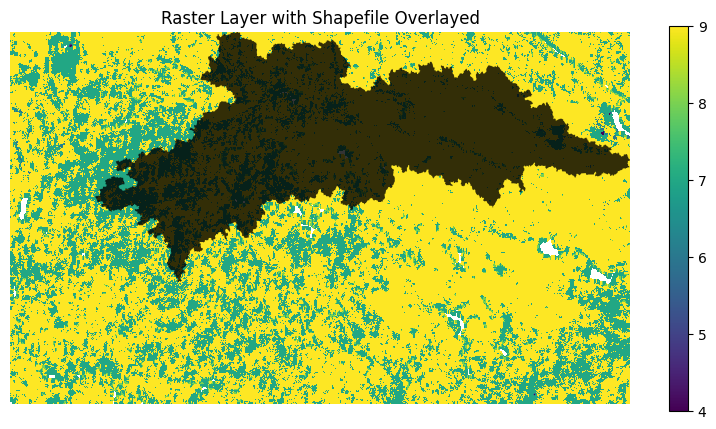


-----------------------------------------------------------------------------------------------
(3) Clip and format soil into shapefile
-----------------------------------------------------------------------------------------------


<ipython-input-7-025a2d879163>:8: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  crop_extent1 = crop_extent.buffer(.001)


Soil layer has been clipped
Layer has been saved to temporary folder
Creating output /content/google_drive/MyDrive/Developers_Magpie_Workflow/temporary_data/Soil/studyArea_soil.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.

-----------------------------------------------------------------------------------------------
(4) Visualize soil outputs
-----------------------------------------------------------------------------------------------


,geometry,Soil_ID
0,"MULTIPOLYGON (((-77.56026 45.93036, -77.56026 ...",4
1,"MULTIPOLYGON (((-77.55702 45.93117, -77.55702 ...",5
2,"MULTIPOLYGON (((-77.52953 45.91176, -77.52711 ...",6
3,"MULTIPOLYGON (((-78.85383 45.59726, -78.85221 ...",7
4,"MULTIPOLYGON (((-78.84009 45.57058, -78.84009 ...",8
5,"MULTIPOLYGON (((-78.97915 45.70317, -78.97915 ...",9


------------------------------------- Soil -------------------------------------


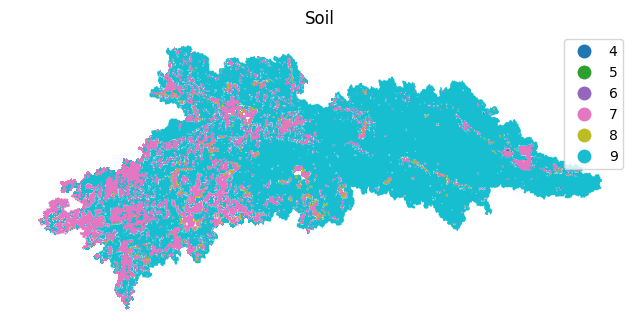

ID (4): 0.0%
ID (5): 0.0%
ID (6): 0.04%
ID (7): 22.69%
ID (8): 1.83%
ID (9): 75.43%

-----------------------------------------------------------------------------------------------
(4) Soil is complete!
-----------------------------------------------------------------------------------------------


<ipython-input-8-6075ab119e21>:31: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  soil_final['area'] = soil_final.area


In [ ]:
if variable['generate_soil'] == "yes" and variable['upload_soil'] == "yes":
  print('Error: Please define whether you are using section 1e to generate the soil layer OR upload your own, users cannot have both as yes')
elif variable['generate_soil'] == 'yes' and variable['upload_soil'] == 'no':
  shp_file_path = os.path.join(variable['main_dir'], 'shapefile')
  # step 1
  shp_file_name = check_projection(shp_file_path)
  # step 1a
  soil_dir = download_soil(shp_file_path, shp_file_name, variable["data_source_soil"], variable["year_of_interest"],variable["band_name_soil"], int(variable['scale_soil']))
  # step 2
  soil_lyr, crop_extent = overlay_shp_on_soil(shp_file_path, shp_file_name)
  # step 3
  clip_and_format(soil_dir, soil_lyr, crop_extent)
  # step 4
  visualize_soil(soil_dir)
  #step 5
  remove_temp_data()
elif variable['generate_soil'] == 'no' and variable['upload_soil'] == 'yes':
  soil_temp_dir = os.path.join(variable['temporary_dir'],'Soil')
  if not os.path.exists(soil_temp_dir):
    os.makedirs(soil_temp_dir)
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1) Upload Soil')
  print('-----------------------------------------------------------------------------------------------')
  print(f'drag-and-drop soil file into following folder: {soil_temp_dir}')
  response = input("Have you uploaded the soil file (yes or no): ")
  if response == "yes":
    for soil_file in os.listdir(soil_temp_dir):
        if soil_file.endswith(".tif"):
          shp_file_path = os.path.join(variable['main_dir'], 'shapefile')
          # step 1
          shp_file_name = check_projection(shp_file_path)
          # step 2
          soil_lyr, crop_extent = overlay_shp_on_soil(shp_file_path, shp_file_name)
          # step 3
          clip_and_format(soil_temp_dir, soil_lyr, crop_extent)
          # step 4
          visualize_soil(soil_temp_dir)
          remove_temp_data()
        elif soil_file.endswith(".shp"):
          upload_soil(soil_temp_dir)
          remove_temp_data()
else:
  print('( ) Soil section has been skipped')